In [1]:
path = './dataset/'

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CardsDataset(Dataset):
    def __init__(self, directory, split='train', transforms=None):
        super().__init__()

        self.transforms = transforms
        self.images = []
        self.classes = set()
        
        for root, dirs, files in os.walk(os.path.join(directory, split)):
            for filename in files:
                if filename.lower().endswith(('.png', 'jpeg', 'jpg')):
                    label = os.path.basename(root)
                    self.classes.add(label)
                    self.images.append((os.path.join(root, filename), label))
                    
        self.cls2idx = {cls: i for i, cls in enumerate(sorted(self.classes))}
        self.idx2cls = {i: cls for cls, i in self.cls2idx.items()}
        self.length = len(self.images)

        if self.length == 0:
            raise RuntimeError(f"No images found in {os.path.join(directory, split)}")

    def __getitem__(self, idx):
        image_path, label = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)

        label_idx = self.cls2idx[label]
        return image, label_idx

    def __len__(self):
        return self.length

    def idx_2_cls(self, idx):
        return self.idx2cls[idx]

In [3]:
import torch
from torchvision.transforms import v2

temp_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

train_dataset_temp = CardsDataset('./dataset/', split='train', transforms=temp_transforms)
train_loader_temp = DataLoader(train_dataset_temp, batch_size=64, num_workers=12)

mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_loader_temp:
    batch_samples = images.size(0)  
    
    images = images.view(batch_samples, images.size(1), -1) 
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

In [4]:
mean, std

(tensor([0.7786, 0.7310, 0.7050]), tensor([0.2236, 0.2728, 0.2727]))

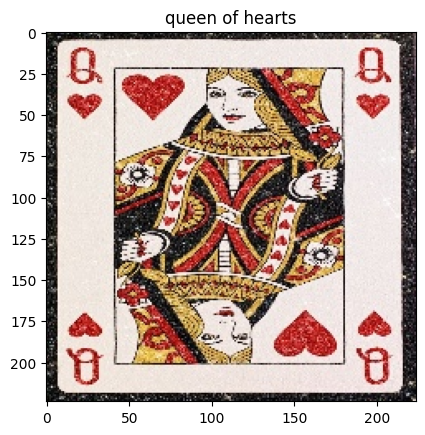

In [5]:
import matplotlib.pyplot as plt

img, idx = train_dataset_temp[0]
cls = train_dataset_temp.idx_2_cls(idx)

plt.imshow(img.permute(1, 2, 0))
plt.title(cls);

In [6]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.RandomResizedCrop((224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(-15, 15)),
    v2.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [7]:
def denormalize(img, mean, std):
    mean = mean.detach().clone().view(-1, 1, 1)
    std = std.detach().clone().view(-1, 1, 1)
    return img * std + mean

In [8]:
train_dataset = CardsDataset('./dataset/', 'train', transforms=transforms)
val_dataset = CardsDataset('./dataset/', 'val', transforms=transforms)
test_dataset = CardsDataset('./dataset/', 'test', transforms=transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=False)

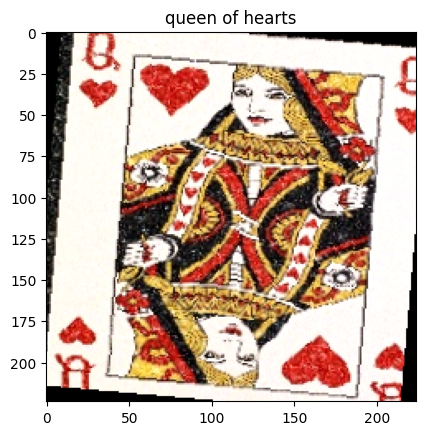

In [9]:
import matplotlib.pyplot as plt

img, idx = train_dataset[0]
denormalized_img = denormalize(img, mean, std)

cls = train_dataset.idx_2_cls(idx)

plt.imshow(denormalized_img.permute(1, 2, 0))
plt.title(cls);

In [10]:
import torch
import torch.nn as nn

class AeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, bottleneck_ratio=4):
        super().__init__()
        bottleneck_channels = out_channels // bottleneck_ratio  

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.block(x) + self.shortcut(x))


class AeNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),  # 224 → 112
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 112 → 56
        )

        self.features = nn.Sequential(
            AeBlock(64, 128, stride=2),   # 56 → 28
            AeBlock(128, 256, stride=2),  # 28 → 14
            AeBlock(256, 512, stride=2)   # 14 → 7
        )

        self.classificator = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.features(x)
        x = self.classificator(x)
        return x